The goal of this notebook is to explore the dynamics of the hoof and mouth disease based on the Keeling algorithm and the state space defined below. Of particular interest is the number of infected farms throughout the course of the outbreak. Insight into this particular disease transition will help determine when data for the risk model should be collected, and when an intervention should be implemented. NOTE: For now I am assuming an outbreak ends when all farms become infected (this usually occurs within 2000 timesteps, however for purposes of computational time I have truncated outbreak time to 1000 time steps). The code in the below cell block generates the location and size of farms. This state will be used to simulate 100 outbreaks and the number of  infected farms per time step will be averaged over the 100 simulations



In [1]:
import numpy as np
from random import randint
Size = 20
N = 75 
np.random.seed(53080)
x = Size*np.random.rand(N)
np.random.seed(23003)
y = Size*np.random.rand(N)  
#np.random.seed(10)
#Cows = np.array([randint(25,250) for p in range(N)])
Cows = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
#np.random.seed(11)
#Sheep = np.array([randint(25,250) for p in range(N)])
Sheep = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


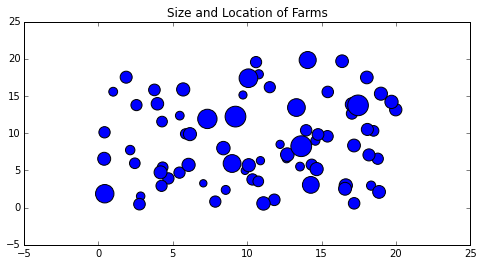

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,s=(Cows+Sheep))
plt.title("Size and Location of Farms")

The code in the cell block below generates one outbreak and returns a vector of the number of farms infected at each time point (up to 1000 time points)

In [106]:
#THE FOLLOWING FUNCTION RUNS THE OUTBREAK FOR 1000 TIMESTEPS (IDEALLY SO ALL FARMS ARE INFECTED)
#BY THE 1000TH STEP. IT RETURNS A LIST OF THE NUMBER OF INFECTED FARMS AT EACH TIME STEP

def Outbreaks(Size,N,Y0,farms,end,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    #Generate dataset (assume there are the same amount of animals at each farm)
    #np.random.seed(10)
    #x = Size*np.random.rand(N)
    #np.random.seed(11)
    #y = Size*np.random.rand(N)
    #Cows = np.array([250]*N)  #Number of cows at each farm
    #Sheep = np.array([250]*N)  #Number of cows at each farm
    Status = np.array([0]*N)    #Initial Status of each farm
    init_ind = np.random.randint(0,N)
    for i in range(Y0):
        Status[init_ind] = 6

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    index_inf = np.where(Status==6)[0].astype(int)
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(Status>5)[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        #for i in range(len(m)):
        #    Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    Maxtime = 0
    while(Maxtime<1000):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
        Maxtime+= 1
    vec = np.c_[list(range(1,len(I)+1)),I]
    return(vec[:,1])

test = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:94: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:103: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [108]:
len(test)

1000

Now the above algorithm is implemented 100 times, so the number of infected farms can be averaged over 100 simulations.

In [112]:
import numpy as np
from random import randint
Num_outbreaks = 99
num_inf = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)
print("Entering for Loop")
for i in range(Num_outbreaks):
    num_inf += Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)
    print(i)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:94: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Entering for Loop
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:103: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


We can now plot our results. Two graphs are presented: the first one is a trajectory across all 1000 timesteps, the second graph takes a closer look at the beginning of the outbreak (recall that we want to implement an intervention, so ideally an action would occur towards to beginning of the outbreak). Based on the second graph, it seems that it would be interesting for data to be collected on day 20 (an average of 3 farms out of the 75 are infected) and an intervention can be implemented on day 35 (an average of 8 farms are infected). 

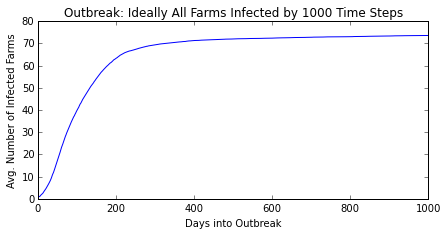

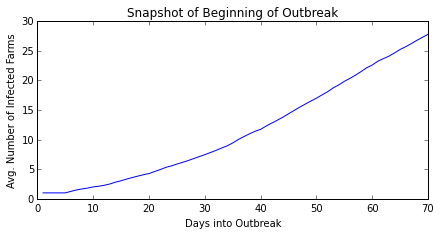

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(1,figsize =(7,7) )
plt.subplot(211)
plt.plot(list(range(1,1001)),num_inf/100)
plt.xlabel('Days into Outbreak')
plt.ylabel('Avg. Number of Infected Farms')
plt.title("Outbreak: Ideally All Farms Infected by 1000 Time Steps")

plt.figure(2,figsize = (7,7))
plt.subplot(211)
plt.plot(list(range(1,71)),num_inf[0:70]/100)
plt.xlabel('Days into Outbreak')
plt.ylabel('Avg. Number of Infected Farms')
plt.title("Snapshot of Beginning of Outbreak")